In [ ]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
from numpy import array
from collections import Counter
import re
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Embedding

* 데이터 불러오기, 데이터 기본 정보

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train=pd.read_csv('/content/drive/MyDrive/최고존엄민민/DACON_NH 투자증권/ipynb+ csv/data/news_train.csv')
test=pd.read_csv('/content/drive/MyDrive/최고존엄민민/DACON_NH 투자증권/ipynb+ csv/data/news_test.csv')
submission=pd.read_csv('/content/drive/MyDrive/최고존엄민민/DACON_NH 투자증권/ipynb+ csv/data/sample_submission.csv')

In [ ]:
print(train.shape)
print(test.shape)

(118745, 6)
(142565, 6)


In [ ]:
print("train  키:\n", train.keys())

train  키:
 Index(['n_id', 'date', 'title', 'content', 'ord', 'info'], dtype='object')


In [ ]:
print("진짜 뉴스 개수 : {}".format(len(train.loc[train['info']==0])))
print("가짜 뉴스 개수 : {}".format(len(train.loc[train['info']==1])))
print("진짜 뉴스 비율 : {}%".format(round((len(train.loc[train['info']==0])) / len(train.index) * 100, 3)))
print("가짜 뉴스 비율 : {}%".format(round((len(train.loc[train['info']==1])) / len(train.index) * 100, 3)))

진짜 뉴스 개수 : 71813
가짜 뉴스 개수 : 46932
진짜 뉴스 비율 : 60.477%
가짜 뉴스 비율 : 39.523%


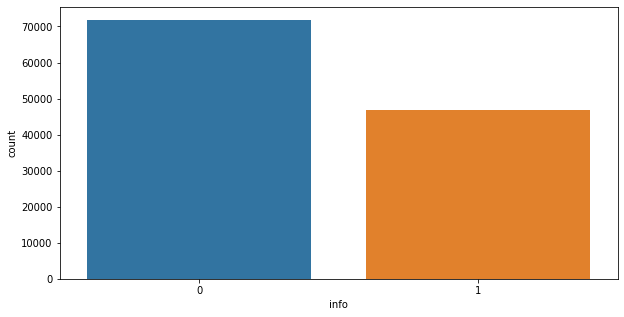

In [ ]:
plt.figure(figsize=(10,5))
sns.countplot(data=train, x="info")

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


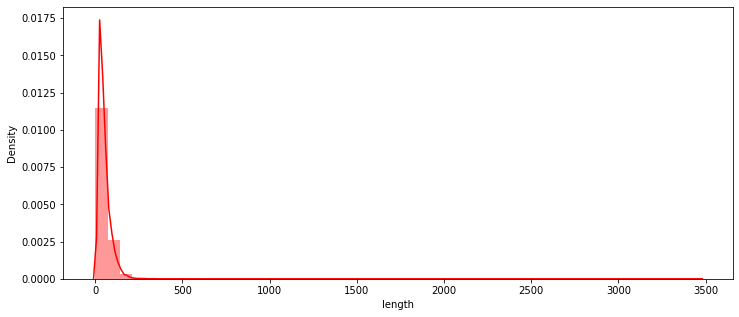

In [ ]:
train['length'] = train['content'].apply(lambda x: len(x))
plt.figure(figsize=(12,5))
sns.distplot(train['length'], color='r')

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


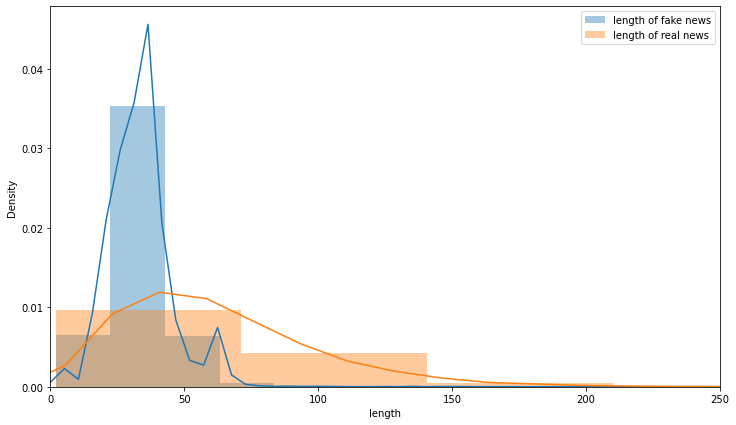

In [ ]:
plt.figure(figsize=(12, 7))
fake = train.loc[train['info']==1]
real = train.loc[train['info']==0]
sns.distplot(fake['length'], label="length of fake news")
sns.distplot(real['length'], label="length of real news")
plt.xlim(0, 250)
plt.legend()

In [ ]:
fake['length'].describe()

count    46932.000000
mean        34.470702
std         20.383651
min          2.000000
25%         27.000000
50%         34.000000
75%         39.000000
max       1022.000000
Name: length, dtype: float64

In [ ]:
real['length'].describe()

count    71813.000000
mean        62.342891
std         43.596060
min          2.000000
25%         34.000000
50%         55.000000
75%         82.000000
max       3469.000000
Name: length, dtype: float64

In [ ]:
def null_check(df):
    null = df.isnull().sum()
    
    null_col=[]

    for i in range(len(df.columns)):
        if (null[i]!=0):
            print(null.index[i],null[i])
            null_col.append(null.index[i])

In [ ]:
null_check(train)

In [ ]:
null_check(test)

* 나이브베이즈

In [ ]:
#케라스의 텍스트 전처리와 관련한 함수중 text_to_word_sequence 함수를 불러 옵니다.
from tensorflow.keras.preprocessing.text import text_to_word_sequence

In [ ]:
false_news= train.query('info == "1"')['content'].unique()

In [1]:
cont=[]
for i in false_news :
    content = re.sub('[^\w\s]', '', i)
    cont.append(content)
cont

In [2]:
# 토큰화 함수를 이용해 전처리 하는 과정입니다.
token = Tokenizer()             # 토큰화 함수 지정
token.fit_on_texts(cont)       # 토큰화 함수에 문장 적용
 
#단어의 빈도수를 계산한 결과를 각 옵션에 맞추어 출력합니다. 
 
print("\n단어 카운트:\n", token.word_counts) 
#Tokenizer()의 word_counts 함수는 순서를 기억하는 OrderedDict클래스를 사용합니다.
 
#출력되는 순서는 랜덤입니다. 
print("\n문장 카운트: ", token.document_count)
print("\n각 단어가 몇개의 문장에 포함되어 있는가:\n", token.word_docs)
print("\n각 단어에 매겨진 인덱스 값:\n",  token.word_index)

In [3]:
# token.word_docs_reverse = sorted(token.word_docs.items(), 
                              key=lambda item: item[1])

for key, value in token.word_docs_reverse:
    print(key, ":", value)

In [ ]:
X_train = train['content']
Y_train = train['info']
print(len(X_train))
print(len(Y_train))

118745
118745


In [ ]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
sequences = tokenizer.texts_to_sequences(X_train)
print(sequences[:5])

[[155, 8698, 250, 1324, 127, 415, 385, 80137, 1509], [305, 302, 306, 133, 229, 304, 15, 124, 307], [296, 308, 162, 205, 89, 114, 24, 233, 218], [222, 268, 242, 155, 146, 112, 110], [64148, 1263, 64149, 12164, 2509, 1489]]


In [ ]:
word_index = tokenizer.word_index
print(word_index)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
print(len(word_index))

163126


In [ ]:
X_data = sequences
print(max(len(l) for l in X_data))

721


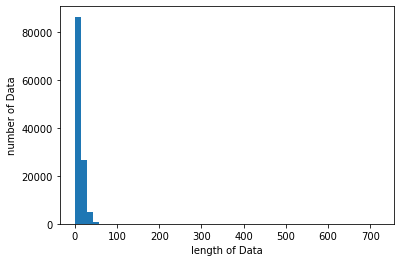

In [ ]:
plt.hist([len(s) for s in X_data], bins=50)
plt.xlabel('length of Data')
plt.ylabel('number of Data')
plt.show()

In [ ]:
from keras.layers import SimpleRNN, Embedding, Dense, LSTM
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
vocab_size = len(word_index)+1
max_len = 721
data = pad_sequences(X_data, maxlen=max_len)
print("data shape: ", data.shape)

data shape:  (118745, 721)


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
tdmvector = CountVectorizer()
X_train_tdm = tdmvector.fit_transform(train['content'])
print(X_train_tdm.shape)
# 모든 훈련데이터의 개수 : 118745
# 모든 훈련데이터에 등장한 단어의 수 : 158244

(118745, 158244)


In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
tfidfv = tfidf_transformer.fit_transform(X_train_tdm)
print(X_train_tdm.shape)

(118745, 158244)


In [ ]:
from sklearn.naive_bayes import MultinomialNB
mod = MultinomialNB()
mod.fit(tfidfv, train['info'])

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [ ]:
MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)

MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)

In [ ]:
from sklearn.metrics import accuracy_score
# 정확도 계산을 위한 함수
#newsdata_test = fetch_20newsgroups(subset='test', shuffle=True)
# 테스트 데이터 갖고오기
X_test_tdm = tdmvector.transform(test['content'])
# 테스트 데이터를 TDM으로 변환
tfidfv_test = tfidf_transformer.transform(X_test_tdm)
# TDM을 TF-IDF 행렬로 변환
predicted = mod.predict(tfidfv_test)
# 테스트 데이터에 대한 예측

#print('정확도:', accuracy_score(newsdata_test.target, predicted))
# 예측값과 실제값 비교

In [ ]:
submission.loc[:,'info'] = np.where(predicted> 0.5, 1,0).reshape(-1)

* 진짜뉴스 단어 리스트 만든 후 진짜 뉴스 처리

In [ ]:
real_news= train.query('info == "0"')['content'].unique()

In [4]:
real_cont=[]
for i in real_news :
    content = re.sub('[^\w\s]', '', i)
    real_cont.append(content)
real_cont

In [ ]:
# 토큰화 함수를 이용해 전처리 하는 과정입니다.
token = Tokenizer()             # 토큰화 함수 지정
token.fit_on_texts(real_cont)       # 토큰화 함수에 문장 적용
 
#단어의 빈도수를 계산한 결과를 각 옵션에 맞추어 출력합니다. 
 
print("\n단어 카운트:\n", token.word_counts) 
#Tokenizer()의 word_counts 함수는 순서를 기억하는 OrderedDict클래스를 사용합니다.
 
#출력되는 순서는 랜덤입니다. 
print("\n문장 카운트: ", token.document_count)
print("\n각 단어가 몇개의 문장에 포함되어 있는가:\n", token.word_docs)
print("\n각 단어에 매겨진 인덱스 값:\n",  token.word_index)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
token.word_docs_reverse = sorted(token.word_docs.items(), 
                              key=lambda item: item[1])

for key, value in token.word_docs_reverse:
    print(key, ":", value)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
여름철 : 15
코리아 : 15
전환이 : 15
확산되면서 : 15
관계없이 : 15
추세다 : 15
지침에 : 15
특징을 : 15
다양하게 : 15
선택 : 15
예정이었던 : 15
상황에서도 : 15
성적을 : 15
2분기부터 : 15
상장된 : 15
만한 : 15
탑재한 : 15
차이 : 15
단계에서 : 15
일본이 : 15
채용을 : 15
현지에서 : 15
이해하고 : 15
전부 : 15
맛을 : 15
않았다며 : 15
16개 : 15
불완전판매 : 15
나라가 : 15
쇼핑몰 : 15
기능성 : 15
넓은 : 15
13개 : 15
가할 : 15
해외주식 : 15
국제유가가 : 15
보복 : 15
전월대비 : 15
개최할 : 15
아니다라며 : 15
렌탈 : 15
분산 : 15
서비스에 : 15
이용이 : 15
절반을 : 15
지역이 : 15
2019 : 15
미국을 : 15
소비자의 : 15
침체로 : 15
효과도 : 15
치열한 : 15
공급에 : 15
팬데믹 : 15
필요성이 : 15
역할 : 15
의류 : 15
아이디어를 : 15
꾸준한 : 15
내에서도 : 15
요금 : 15
물품을 : 15
효율적인 : 15
15일까지 : 15
주장이 : 15
파악하고 : 15
경우에 : 15
전망에 : 15
건강과 : 15
엔진 : 15
3일까지 : 15
캐시백 : 15
명품 : 15
목소리도 : 15
놓인 : 15
6개월간 : 15
외환시장에서 : 15
차단 : 15
8명 : 15
28일까지 : 15
확진된 : 15
숨졌다 : 15
만날 : 15
호응을 : 15
주차 : 15
대상이다 : 15
원인으로 : 15
가득 : 15
선호하는 : 15
기관의 : 15
불과했다 : 15
발행한 : 15
가입한 : 15
제한이 : 15
전달할 : 15
긍정적 : 15
모두를 : 15
ma : 15
청년들의 : 15
품목은 : 15
비대면으로 : 15
정례 : 15
주민의 : 15
소감을 : 15
담당하

In [ ]:
real_word=["기자","밝혔다","말했다","설명했다","전했다","했다","예정이다","덧붙였다"] #false 121, real 16960

In [ ]:
from tqdm import tqdm
test_content = test['content'].values
for idx, sent in enumerate(tqdm(test_content)):
  for i in real_word :
    if i in sent :
      print(sent)
      submission['info'].iloc[idx] = 0 # 같으면 0

* train의 진짜 뉴스와 동일한 test 데이터는 진짜 뉴스 처리

In [ ]:
train_unique_real_sentence = train.query('info == "0"')['content'].unique()
test_unique_sentence = test['content'].unique()

print(len(train_unique_real_sentence))
print(len(test_unique_sentence))
print(len(set(train_unique_real_sentence) & set(test_unique_sentence)))

40370
65827
614


In [ ]:
from tqdm import tqdm

test_content = test['content'].values
for idx, sent in enumerate(tqdm(test_content)) :

    if sent in train_unique_real_sentence: 
        submission['info'].iloc[idx] = 0 # 같으면 0

  0%|          | 0/142565 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
100%|██████████| 142565/142565 [02:14<00:00, 1060.39it/s]


* train의 가짜뉴스와 동일한 test 데이터는 모두 가짜뉴스 처리

In [ ]:
train_unique_ad_sentence = train.query('info == "1"')['content'].unique()
test_unique_sentence = test['content'].unique()

print(len(train_unique_ad_sentence))
print(len(test_unique_sentence))
print(len(set(train_unique_ad_sentence) & set(test_unique_sentence)))

5794
65827
1973


In [ ]:
from tqdm import tqdm
test_content = test['content'].values
for idx, sent in enumerate(tqdm(test_content)) : #Test 데이터에 있는 모든 content들에 대하여
    if sent in train_unique_ad_sentence: # Train 데이터의 광고성 문구와 같은지 비교
        submission['info'].iloc[idx] = 1 # 같으면 1

  0%|          | 0/142565 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
100%|██████████| 142565/142565 [00:29<00:00, 4799.10it/s]


In [ ]:
submission.loc[:,["id","info"]].to_csv("sample_submission53.csv", index = False)
submission

,id,info
0,NEWS00237_1,0
1,NEWS00237_2,0
2,NEWS00237_3,0
3,NEWS00237_4,0
4,NEWS00237_5,0
...,...,...
142560,NEWS09482_72,1
142561,NEWS09482_73,1
142562,NEWS09482_74,1
142563,NEWS09482_75,1
